# Use VPG with Baseline to Play CartPole-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0')
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:00:41 [INFO] env: <CartPoleEnv<CartPole-v0>>
00:00:41 [INFO] action_space: Discrete(2)
00:00:41 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
00:00:41 [INFO] reward_range: (-inf, inf)
00:00:41 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
00:00:41 [INFO] _max_episode_steps: 200
00:00:41 [INFO] _elapsed_steps: None
00:00:41 [INFO] id: CartPole-v0
00:00:41 [INFO] entry_point: gym.envs.classic_control:CartPoleEnv
00:00:41 [INFO] reward_threshold: 195.0
00:00:41 [INFO] nondeterministic: False
00:00:41 [INFO] max_episode_steps: 200
00:00:41 [INFO] _kwargs: {}
00:00:41 [INFO] _env_name: CartPole


In [3]:
class VPGwBaselineAgent:
    def __init__(self, env,):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.policy_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[],
                output_size=self.action_n, output_activator=nn.Softmax(1))
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.005)
        self.baseline_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[])
        self.baseline_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.01)
        self.baseline_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None, use_bias=False):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size, bias=use_bias))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, terminated):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.policy_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, terminated, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
        reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
        action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
        arange_tensor = torch.arange(state_tensor.shape[0], dtype=torch.float)

        # update baseline
        discount_tensor = self.gamma ** arange_tensor
        discounted_reward_tensor = discount_tensor * reward_tensor
        discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
        return_tensor = discounted_return_tensor / discount_tensor
        pred_tensor = self.baseline_net(state_tensor)
        psi_tensor = (discounted_return_tensor - discount_tensor *
                pred_tensor).detach()
        baseline_loss_tensor = self.baseline_loss(pred_tensor,
                return_tensor.unsqueeze(1))
        self.baseline_optimizer.zero_grad()
        baseline_loss_tensor.backward()
        self.baseline_optimizer.step()

        # update policy
        all_pi_tensor = self.policy_net(state_tensor)
        pi_tensor = torch.gather(all_pi_tensor, 1,
                action_tensor.unsqueeze(1)).squeeze(1)
        log_pi_tensor = torch.log(torch.clamp(pi_tensor, 1e-6, 1.))
        policy_loss_tensor = -(psi_tensor * log_pi_tensor).mean()
        self.policy_optimizer.zero_grad()
        policy_loss_tensor.backward()
        self.policy_optimizer.step()


agent = VPGwBaselineAgent(env)

00:00:41 [INFO] ==== train ====
00:00:42 [INFO] train episode 0: reward = 21.00, steps = 21
00:00:42 [INFO] train episode 1: reward = 45.00, steps = 45
00:00:42 [INFO] train episode 2: reward = 17.00, steps = 17
00:00:42 [INFO] train episode 3: reward = 38.00, steps = 38
00:00:42 [INFO] train episode 4: reward = 28.00, steps = 28
00:00:42 [INFO] train episode 5: reward = 101.00, steps = 101
00:00:42 [INFO] train episode 6: reward = 10.00, steps = 10
00:00:42 [INFO] train episode 7: reward = 63.00, steps = 63
00:00:42 [INFO] train episode 8: reward = 39.00, steps = 39
00:00:42 [INFO] train episode 9: reward = 30.00, steps = 30
00:00:42 [INFO] train episode 10: reward = 77.00, steps = 77
00:00:42 [INFO] train episode 11: reward = 21.00, steps = 21
00:00:42 [INFO] train episode 12: reward = 17.00, steps = 17
00:00:42 [INFO] train episode 13: reward = 25.00, steps = 25
00:00:42 [INFO] train episode 14: reward = 40.00, steps = 40
00:00:42 [INFO] train episode 15: reward = 19.00, steps = 19


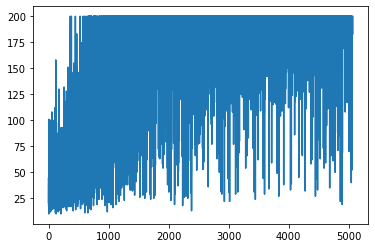

In [4]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode,
            mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-20:]) > 199:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()